# Multi Stock Close-EWMA Crossover Strategy

- long when close > EWMA21 (i.e. close crosses above close)
- short when close < EWMA21 (i.e. close crosses below close)

## Import libraries

In [1]:
pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import requests
import bs4 as bs
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
plt.style.use("seaborn-whitegrid")

## Load stock data

In [3]:
# get S&P500 tickers from Wikipedia
resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'id': 'constituents'})
tickers = []

for row in table.find_all('tr')[1:]:
		ticker = row.find('td').text.strip()
		if "." in ticker:
			ticker = ticker.replace('.','-')
		tickers.append(ticker)

In [4]:
df = yf.download(tickers=tickers, period="max", interval="1d", group_by="ticker", auto_adjust=True)
df

[*********************100%***********************]  505 of 505 completed


KSU              ...        TSN             
                  Open        High  ...      Close       Volume
Date                                ...                        
1962-01-02         NaN         NaN  ...        NaN          NaN
1962-01-03         NaN         NaN  ...        NaN          NaN
1962-01-04         NaN         NaN  ...        NaN          NaN
1962-01-05         NaN         NaN  ...        NaN          NaN
1962-01-08         NaN         NaN  ...        NaN          NaN
...                ...         ...  ...        ...          ...
2021-08-06  271.480011  274.179993  ...  71.120003  136930000.0
2021-08-09  271.160004  272.500000  ...  77.300003  523830000.0
2021-08-10  286.359985  291.290009  ...  79.550003  330260000.0
2021-08-11  289.230011  293.140015  ...  80.180000  213050000.0
2021-08-12  291.640015  292.920013  ...  80.040001    1686382.0

[15023 rows x 2525 columns]

## Get adjusted close prices

In [5]:
sp_close = df.copy()
sp_close = sp_close.loc[:, sp_close.columns.get_level_values(1)=="Close"].fillna(method="ffill") # ffill to fill any missing values (hilidays) with previous day's value
sp_close.columns = sp_close.columns.get_level_values(0)
sp_close

,KSU,AAL,DISCA,ADI,PEP,NLSN,CSX,CVS,SNA,PSX,SRE,SJM,PAYC,NTAP,HAS,MPC,DISH,ALGN,BDX,TSCO,COF,BWA,AMGN,AKAM,F,KIM,SNPS,WMB,VMC,KEY,HUM,PGR,LRCX,CDNS,MCK,RSG,XEL,MSCI,PNW,AAPL,...,NLOK,LEN,UPS,FFIV,BR,FOXA,IP,FRC,UNH,LHX,AMP,CMA,NWSA,PWR,CFG,IQV,TXT,KMI,PSA,RTX,ATO,TFC,DGX,DAL,TMO,WLTW,BF-B,ICE,CL,NFLX,ADM,COG,HSY,FIS,JCI,HAL,MMM,ZTS,HES,TSN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.078698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.063972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.060291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.071334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.049245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-06,271.769989,21.020000,29.040001,171.130005,154.330002,23.180000,32.299999,81.250000,224.440002,73.959999,132.330002,127.900002,466.450012,82.169998,97.989998,57.410000,41.970001,693.669983,241.039993,187.270004,165.949997,45.540001,230.149994,114.570000,13.80,21.850000,292.429993,25.059999,181.160004,20.330000,419.209991,96.919998,647.960022,151.070007,199.929993,118.309998,69.080002,628.900024,80.339996,146.139999,...,23.990000,104.050003,192.600006,211.440002,173.369995,36.480000,57.889999,203.750000,415.119995,231.289993,265.589996,72.250000,24.719999,92.349998,43.970001,248.960007,72.610001,17.120001,304.730011,87.580002,100.889999,56.138428,146.600006,40.320000,538.200012,215.979996,70.339996,120.000000,78.629997,520.549988,60.290001,16.170671,178.589996,133.820007,72.070000,20.000000,198.130005,201.880005,73.139999,71.120003
2021-08-09,269.600006,20.559999,29.230000,171.309998,154.350006,22.940001,32.389999,81.650002,223.460007,73.010002,131.259995,129.009995,468.559998,82.250000,98.199997,57.220001,42.250000,686.559998,238.539993,187.580002,166.210007,45.580002,227.889999,115.089996,13.75,21.750000,291.399994,24.760000,183.229996,20.200001,416.649994,97.120003,640.500000,150.289993,196.830002,117.820000,69.120003,627.679993,80.320000,146.089996,...,23.889999,103.779999,190.979996,210.080002,172.929993,36.509998,58.630001,202.759995,410.869995,229.000000,265.609985,71.989998,24.410000,92.080002,43.880001,247.660004,72.239998,17.040001,309.779999,87.080002,101.120003,56.257454,147.899994,39.290001,541.15

## Visualise adjusted close prices (e.g. AAPL)

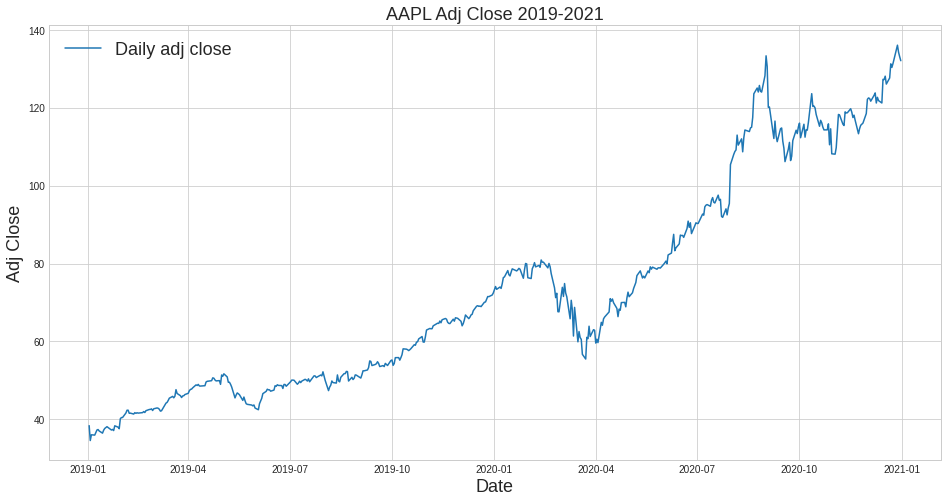

In [6]:
plt.figure(figsize=(16,8))
plt.plot(sp_close.loc["2019-01-01":"2021-01-01", "AAPL"], label="Daily adj close")
plt.title("AAPL Adj Close 2019-2021", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj Close", fontsize=18)
plt.show()

## Exponentially Weighted Moving Average (EWMA)

In [7]:
def EWMA(df, period):
  return df.ewm(span=period, adjust=True).mean()

In [8]:
sp_ewma = sp_close.copy()
sp_ewma = EWMA(sp_ewma, 21)
sp_ewma

,KSU,AAL,DISCA,ADI,PEP,NLSN,CSX,CVS,SNA,PSX,SRE,SJM,PAYC,NTAP,HAS,MPC,DISH,ALGN,BDX,TSCO,COF,BWA,AMGN,AKAM,F,KIM,SNPS,WMB,VMC,KEY,HUM,PGR,LRCX,CDNS,MCK,RSG,XEL,MSCI,PNW,AAPL,...,NLOK,LEN,UPS,FFIV,BR,FOXA,IP,FRC,UNH,LHX,AMP,CMA,NWSA,PWR,CFG,IQV,TXT,KMI,PSA,RTX,ATO,TFC,DGX,DAL,TMO,WLTW,BF-B,ICE,CL,NFLX,ADM,COG,HSY,FIS,JCI,HAL,MMM,ZTS,HES,TSN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.078698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.070984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.067075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.068297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.063728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-06,269.551091,20.826797,29.082864,166.751463,154.450288,23.853993,32.120553,82.187674,222.604493,75.885962,132.176063,130.554052,402.928450,80.048058,97.483630,55.884898,41.682388,658.147496,249.554560,184.787107,159.997981,47.630617,240.692624,117.050968,13.991959,21.040547,283.784277,25.406627,177.952717,19.841331,440.641029,95.833827,633.705328,144.483712,199.236334,115.892495,68.447586,586.893330,82.372331,144.768334,...,25.356779,102.289728,199.967667,200.113915,170.922020,36.138946,58.785667,195.618153,413.452485,226.757570,253.210170,69.096475,24.777550,90.179649,43.441805,247.215460,69.102507,17.453400,308.942506,86.475005,99.579086,54.664693,140.120420,40.881616,527.053234,216.861967,71.848842,119.335315,81.112811,520.586463,59.441761,16.117455,177.890502,142.094991,70.586509,20.715461,199.011777,200.146788,76.969283,71.714364
2021-08-09,269.555538,20.802543,29.096240,167.165875,154.441172,23.770903,32.145048,82.138794,222.682267,75.624511,132.092784,130.413683,408.894954,80.248235,97.548754,56.006271,41.733989,660.730450,248.553236,185.041007,160.562711,47.444197,239.528749,116.872698,13.969963,21.105042,284.476614,25.347843,178.432469,19.873938,438.460026,95.950752,634.323026,145.011556,199.017576,116.067723,68.508715,590.601208,82.185755,144.888485,...,25.223435,102.425207,199.150606,201.019923,171.104563,36.172678,58.771515,196.267411,413.217713,226.961427,254.337426,69.359522,24.744137,90.352409,43.481641,247.255873,69.387734,17.415818,309.018642,86.530005,99.719169,54.809490,140.827654,40.736924,

## Visualise EWMA on top of adjusted close (e.g. AAPL)

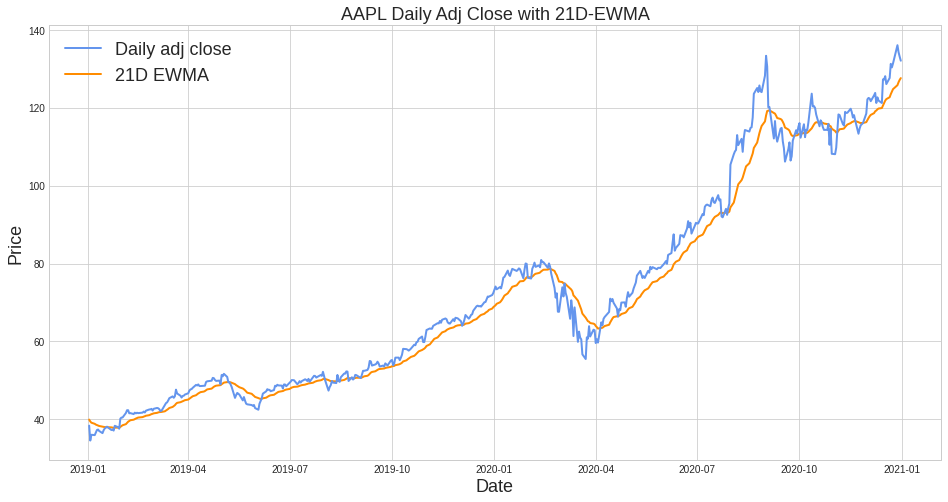

In [9]:
plt.figure(figsize=(16,8))
plt.plot(sp_close.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="Daily adj close", linewidth=2, color="cornflowerblue", zorder=2)
plt.plot(sp_ewma.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="21D EWMA", linewidth=2, color="darkorange", zorder=1)
plt.title("AAPL Daily Adj Close with 21D-EWMA", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.show()

## Compute long and short signals

- Long: close > EWMA21
- Short: close < EWMA21

In [10]:
def get_long_short(close, moving_avg):
  # create initial long/short signal dataframe with all zeros
  long_short = (close*0).fillna(0).astype(np.int)
  # create long signals when close > moving avg
  long_signals = (close > moving_avg).astype(np.int)
  # create short signals when close < moving avg
  short_signals = (close < moving_avg).astype(np.int)
  # combine both long and short signals
  long_short = long_short + long_signals - short_signals

  return long_short

In [11]:
# compute signals b/w 2019 - 2021 and cut ewma and close to that timeframe too
sp_close = sp_close.loc["2019-01-01":"2021-01-01", :].dropna(axis=1)
sp_ewma = sp_ewma.loc["2019-01-01":"2021-01-01", :].dropna(axis=1)
signal = get_long_short(sp_close, sp_ewma)
signal

,KSU,AAL,DISCA,ADI,PEP,NLSN,CSX,CVS,SNA,PSX,SRE,SJM,PAYC,NTAP,HAS,MPC,DISH,ALGN,BDX,TSCO,COF,BWA,AMGN,AKAM,F,KIM,SNPS,WMB,VMC,KEY,HUM,PGR,LRCX,CDNS,MCK,RSG,XEL,MSCI,PNW,AAPL,...,FTV,NLOK,LEN,UPS,FFIV,BR,IP,FRC,UNH,LHX,AMP,CMA,NWSA,PWR,CFG,IQV,TXT,KMI,PSA,RTX,ATO,TFC,DGX,DAL,TMO,WLTW,BF-B,ICE,CL,NFLX,ADM,COG,HSY,FIS,JCI,HAL,MMM,ZTS,HES,TSN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019-01-03,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2019-01-04,1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1,-1,1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,1,-1,1,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,1,-1,-1,-1,1,1,1,-1,-1,-1,1
2019-01-07,1,1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,1,1,1,1,1,1,-1,-1,1,1,1,1,-1,1,-1,-1,...,-1,-1,1,-1,1,1,1,-1,-1,-1,1,1,1,1,1,1,-1,1,-1,-1,-1,1,-1,-1,-1,1,1,-1,-1,1,-1,1,-1,1,1,1,-1,-1,1,1
2019-01-08,1,-1,1,1,-1,1,-1,-1,1,1,1,1,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,1,1,1,1,1,1,-1,-1,1,1,1,1,-1,1,-1,-1,...,-1,-1,1,-1,1,1,1,-1,-1,-1,1,1,1,1,1,1,-1,1,-1,-1,-1,1,-1,-1,1,1,1,-1,-1,1,1,1,1,1,1,1,-1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,1,-1,1,1,1,1,1,-1,-1,1,-1,1,1,1,1,1,-1,1,1,1,1,1,-1,1,-1,-1,1,-1,1,1,1,1,1,1,-1,-1,-1,1,-1,1,...,1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,-1,1,-1,-1,1,-1,-1,-1,1,-1,1,1,1,-1,-1,1,-1,1,1,1,-1,1,-1
2020-12-28,1,1,1,1,1,1,1,-1,-1,1,-1,1,1,1,1,1,-1,1,1,1,1,1,-1,1,-1,1,1,-1,1,1,1,1,1,1,1,1,-1,1,-1,1,...,-1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,-1,1,1,-1,1,-1,-1,-1,-1,1,1,1,1,1,-1,1,-1,1,1,1,1,1,-1
2020-12-29,1,1,1,1,1,1,-1,-1,-1,1,-1,-1,1,1,1,1,-1,1,1,1,1,-1,1,1,-1,-1,1,-1,1,1,1,1,-1,1,1,-1,-1,1,-1,1,...,-1,1,1,-1,1,1,-1,1,1,-1,1,1,1,1,1,1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,-1,-1,1,-1,1,-1,1,1,-1,-1


## Filter signal

Filter out all consecutive-equal signals, so only long/short changes remain.

In [12]:
def filter_signal(signal):

  filtered_signal = signal.copy()
  for ticker in filtered_signal:
    filtered_signal.loc[filtered_signal[ticker].shift(1).eq(filtered_signal[ticker]), ticker] = 0
  
  return filtered_signal

In [13]:
filtered_signal = filter_signal(signal)
filtered_signal

,KSU,AAL,DISCA,ADI,PEP,NLSN,CSX,CVS,SNA,PSX,SRE,SJM,PAYC,NTAP,HAS,MPC,DISH,ALGN,BDX,TSCO,COF,BWA,AMGN,AKAM,F,KIM,SNPS,WMB,VMC,KEY,HUM,PGR,LRCX,CDNS,MCK,RSG,XEL,MSCI,PNW,AAPL,...,FTV,NLOK,LEN,UPS,FFIV,BR,IP,FRC,UNH,LHX,AMP,CMA,NWSA,PWR,CFG,IQV,TXT,KMI,PSA,RTX,ATO,TFC,DGX,DAL,TMO,WLTW,BF-B,ICE,CL,NFLX,ADM,COG,HSY,FIS,JCI,HAL,MMM,ZTS,HES,TSN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019-01-03,-1,0,0,0,0,0,0,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,-1,-1,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2019-01-04,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,1,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0
2019-01-07,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,-1,0,0,0,1,0,0,0,0,0,0,1,0
2019-01-08,0,-1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0,-1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,-1,0,0,0,0,1,0,0,-1,1,0,0,0,0,0,0,0
2020-12-28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2020-12-29,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,-1,1,0,0,-1,0,0,0,0,0,0,-1,0,0,-1,0,0,0,0,...,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,-1,0


## Visualise long and short signals (e.g. AAPL)

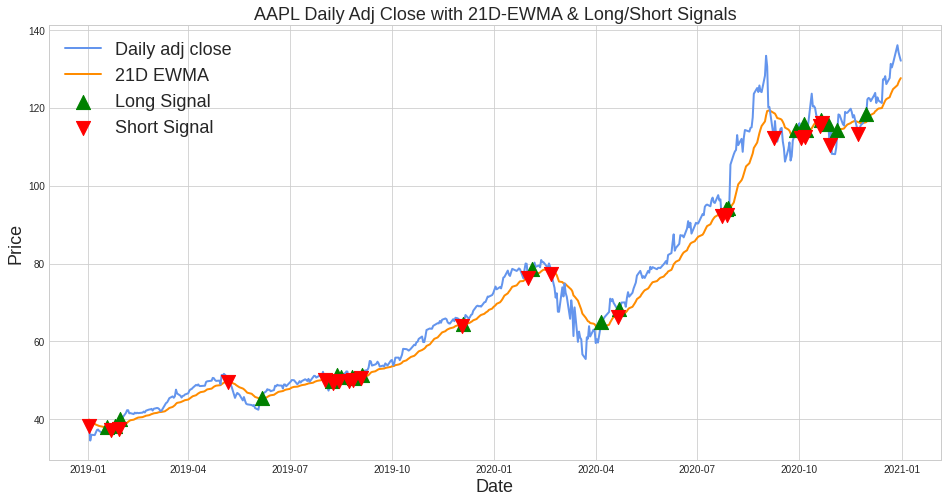

In [14]:
plt.figure(figsize=(16,8))
plt.plot(sp_close.loc[:,"AAPL"], alpha=1.0, label="Daily adj close", linewidth=2, color="cornflowerblue", zorder=2)
plt.plot(sp_ewma.loc[:,"AAPL"], alpha=1.0, label="21D EWMA", linewidth=2, color="darkorange", zorder=1)
plt.scatter(filtered_signal.index, np.where(filtered_signal.loc[:, "AAPL"]==1, sp_close.loc[:, "AAPL"], np.nan), alpha=1, label="Long Signal", marker="^", color="green", s=200, zorder=4)
plt.scatter(filtered_signal.index, np.where(filtered_signal.loc[:, "AAPL"]==-1, sp_close.loc[:, "AAPL"], np.nan), alpha=1, label="Short Signal", marker="v", color="red", s=200, zorder=5)
plt.title("AAPL Daily Adj Close with 21D-EWMA & Long/Short Signals", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.show()

## Signal returns

For each long/short signal get the price of the next (opposite) signal to compute the returns made in the period between signal changes.

In [15]:
def get_lookahead_returns(close, signal):

  entry_signals = signal.copy()
  entry_signals = entry_signals[signal!=0]

  entry_prices = close.copy()
  entry_prices = entry_prices[signal!=0]

  price_returns = entry_prices.copy()

  for ticker in entry_prices:
    valid_indexes = entry_prices.loc[:, ticker].index.get_indexer(entry_prices.loc[:, ticker].index[~entry_prices.loc[:, ticker].isnull()])
    for i in range(len(valid_indexes)):
      if i < (len(valid_indexes)-1):
        price_returns.loc[:, ticker].iloc[valid_indexes[i]] = (entry_prices.loc[:, ticker].iloc[valid_indexes[i+1]] / entry_prices.loc[:, ticker].iloc[valid_indexes[i]]) - 1
      else:
        price_returns.loc[:, ticker].iloc[valid_indexes[i]] = (close.loc[:, ticker].iloc[-1] / entry_prices.loc[:, ticker].iloc[valid_indexes[i]]) - 1

  signal_returns = entry_signals * price_returns

  return signal_returns

In [16]:
signal_returns = get_lookahead_returns(sp_close, filtered_signal)
signal_returns

,KSU,AAL,DISCA,ADI,PEP,NLSN,CSX,CVS,SNA,PSX,SRE,SJM,PAYC,NTAP,HAS,MPC,DISH,ALGN,BDX,TSCO,COF,BWA,AMGN,AKAM,F,KIM,SNPS,WMB,VMC,KEY,HUM,PGR,LRCX,CDNS,MCK,RSG,XEL,MSCI,PNW,AAPL,...,FTV,NLOK,LEN,UPS,FFIV,BR,IP,FRC,UNH,LHX,AMP,CMA,NWSA,PWR,CFG,IQV,TXT,KMI,PSA,RTX,ATO,TFC,DGX,DAL,TMO,WLTW,BF-B,ICE,CL,NFLX,ADM,COG,HSY,FIS,JCI,HAL,MMM,ZTS,HES,TSN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-0.035317,-0.014470,-0.054588,0.007914,-0.007229,-0.039099,-0.032768,-0.013459,-0.013563,-0.013845,-0.063413,-0.061781,-0.036842,-0.025359,-0.041385,-0.033702,-0.092736,-0.023105,-0.033488,-0.037456,-0.029511,-0.006262,-0.015216,-0.072022,-0.049367,-0.052126,-0.020345,-0.050401,-0.040373,-0.037284,-0.02493,-0.034948,-0.048228,-0.039325,-0.020253,-0.017894,-0.034633,-0.038111,-0.033788,0.006966,...,-0.027914,-0.05227,-0.031281,-0.017488,-0.016379,-0.021771,-0.030229,-0.078057,-0.054951,-0.028316,-0.025658,-0.025237,-0.051800,-0.041778,-0.036382,-0.025282,-0.039705,-0.027848,-0.045883,-0.023546,-0.050195,-0.019374,-0.031155,-0.003594,-0.048127,-0.012894,-0.021489,-0.004513,-0.034599,0.311515,-0.042735,-0.022949,-0.009769,-0.003451,-0.023279,-0.041026,-0.00707,-0.024384,-0.133523,-0.021368
2019-01-03,-0.043394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.036505,-0.045339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.034183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.048849,-0.041657,NaN,NaN,NaN,-0.037215,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088090
2019-01-04,0.066770,NaN,NaN,NaN,NaN,0.014724,NaN,NaN,0.006301,0.009908,NaN,NaN,NaN,NaN,NaN,0.023682,-0.023692,NaN,NaN,NaN,-0.016847,0.109477,-0.017857,NaN,NaN,NaN,NaN,0.133333,-0.012903,0.050064,NaN,NaN,0.004998,0.546463,NaN,0.068423,NaN,0.473817,NaN,NaN,...,NaN,NaN,0.142274,NaN,NaN,NaN,0.079508,NaN,NaN,NaN,0.162763,0.182377,NaN,0.122554,0.140393,NaN,NaN,0.238476,NaN,NaN,NaN,0.103423,NaN,NaN,NaN,NaN,-0.012962,-0.030263,NaN,NaN,NaN,NaN,NaN,0.017783,0.162188,0.073188,NaN,NaN,NaN,NaN
2019-01-07,NaN,-0.016085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480058,NaN,0.044567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.129726,0.351446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.128467,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.005921,-0.002676,NaN,NaN,NaN,NaN,NaN,NaN,0.040067,NaN,NaN,0.172611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116153,NaN,-0.015400,NaN,NaN,NaN,0.031531,NaN,NaN,NaN,NaN,NaN,NaN,0.182331,NaN
2019-01-08,NaN,-0.030845,-0.023495,0.241076,NaN,NaN,NaN,NaN,NaN,NaN,0.012508,0.027076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092443,NaN,NaN,NaN,NaN,NaN,-0.019906,NaN,-0.007326,NaN,NaN,NaN,NaN,-0.023573,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,NaN,-0.025543,NaN,NaN,NaN,NaN,-0.007996,NaN,NaN,NaN,NaN,-0.006547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.021265,NaN,NaN,0.029021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005123,NaN,NaN,NaN,-0.020891,NaN,NaN,NaN,NaN,-0.003645,NaN,NaN,0.038961,0.015872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,NaN,-0.018057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005163,-0.008297,NaN,NaN,NaN,NaN,...,-0.008699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004106,NaN,NaN,NaN,NaN,NaN,-0.016651,0.013784,NaN,NaN,NaN,-0.005030,NaN,NaN,NaN,NaN

## Portfolio returns (equal weights)

- long or short 1 share each
- weight for each stocks return is $w=\frac{1}{n}$

In [17]:
def compute_portfolio_returns(signal_returns):
  portfolio_returns = signal_returns / len(signal_returns.columns)
  return portfolio_returns

In [18]:
pfolio_returns = compute_portfolio_returns(signal_returns)
pfolio_returns

,KSU,AAL,DISCA,ADI,PEP,NLSN,CSX,CVS,SNA,PSX,SRE,SJM,PAYC,NTAP,HAS,MPC,DISH,ALGN,BDX,TSCO,COF,BWA,AMGN,AKAM,F,KIM,SNPS,WMB,VMC,KEY,HUM,PGR,LRCX,CDNS,MCK,RSG,XEL,MSCI,PNW,AAPL,...,FTV,NLOK,LEN,UPS,FFIV,BR,IP,FRC,UNH,LHX,AMP,CMA,NWSA,PWR,CFG,IQV,TXT,KMI,PSA,RTX,ATO,TFC,DGX,DAL,TMO,WLTW,BF-B,ICE,CL,NFLX,ADM,COG,HSY,FIS,JCI,HAL,MMM,ZTS,HES,TSN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-0.000071,-0.000029,-0.000110,0.000016,-0.000015,-0.000079,-0.000066,-0.000027,-0.000027,-0.000028,-0.000128,-0.000124,-0.000074,-0.000051,-0.000083,-0.000068,-0.000187,-0.000046,-0.000067,-0.000075,-0.000059,-0.000013,-0.000031,-0.000145,-0.000099,-0.000105,-0.000041,-0.000101,-0.000081,-0.000075,-0.00005,-0.00007,-0.000097,-0.000079,-0.000041,-0.000036,-0.00007,-0.000077,-0.000068,0.000014,...,-0.000056,-0.000105,-0.000063,-0.000035,-0.000033,-0.000044,-0.000061,-0.000157,-0.000111,-0.000057,-0.000052,-0.000051,-0.000104,-0.000084,-0.000073,-0.000051,-0.00008,-0.000056,-0.000092,-0.000047,-0.000101,-0.000039,-0.000063,-0.000007,-0.000097,-0.000026,-0.000043,-0.000009,-0.000070,0.000627,-0.000086,-0.000046,-0.000020,-0.000007,-0.000047,-0.000083,-0.000014,-0.000049,-0.000269,-0.000043
2019-01-03,-0.000087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000073,-0.000091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000098,-0.000084,NaN,NaN,NaN,-0.000075,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000177
2019-01-04,0.000134,NaN,NaN,NaN,NaN,0.000030,NaN,NaN,0.000013,0.000020,NaN,NaN,NaN,NaN,NaN,0.000048,-0.000048,NaN,NaN,NaN,-0.000034,0.000220,-0.000036,NaN,NaN,NaN,NaN,0.000268,-0.000026,0.000101,NaN,NaN,0.000010,0.001100,NaN,0.000138,NaN,0.000953,NaN,NaN,...,NaN,NaN,0.000286,NaN,NaN,NaN,0.000160,NaN,NaN,NaN,0.000327,0.000367,NaN,0.000247,0.000282,NaN,NaN,0.000480,NaN,NaN,NaN,0.000208,NaN,NaN,NaN,NaN,-0.000026,-0.000061,NaN,NaN,NaN,NaN,NaN,0.000036,0.000326,0.000147,NaN,NaN,NaN,NaN
2019-01-07,NaN,-0.000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000966,NaN,0.000090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000261,0.000707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000258,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.000012,-0.000005,NaN,NaN,NaN,NaN,NaN,NaN,0.000081,NaN,NaN,0.000347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000234,NaN,-0.000031,NaN,NaN,NaN,0.000063,NaN,NaN,NaN,NaN,NaN,NaN,0.000367,NaN
2019-01-08,NaN,-0.000062,-0.000047,0.000485,NaN,NaN,NaN,NaN,NaN,NaN,0.000025,0.000054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000186,NaN,NaN,NaN,NaN,NaN,-0.000040,NaN,-0.000015,NaN,NaN,NaN,NaN,-0.000047,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,NaN,-0.000051,NaN,NaN,NaN,NaN,-0.000016,NaN,NaN,NaN,NaN,-0.000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000043,NaN,NaN,0.000058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000010,NaN,NaN,NaN,-0.000042,NaN,NaN,NaN,NaN,-0.000007,NaN,NaN,0.000078,0.000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,NaN,-0.000036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000010,-0.000017,NaN,NaN,NaN,NaN,...,-0.000018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000008,NaN,NaN,NaN,NaN,NaN,-0.000034,0.000028,NaN,NaN,NaN,-0.000010,NaN,NaN,NaN,NaN,

In [19]:
xsectional_pfolio_returns = pfolio_returns.sum(axis=1)
xsectional_pfolio_returns

Date
2019-01-02   -0.025463
2019-01-03   -0.006406
2019-01-04    0.030301
2019-01-07    0.014353
2019-01-08    0.007906
                ...   
2020-12-24    0.000284
2020-12-28   -0.000374
2020-12-29   -0.001507
2020-12-30    0.000244
2020-12-31    0.000000
Length: 505, dtype: float64

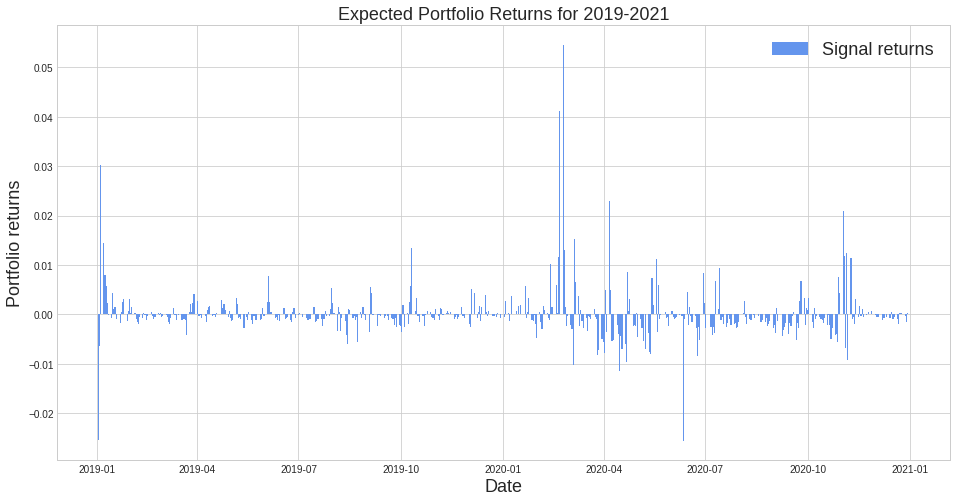

In [20]:
plt.figure(figsize=(16,8))
plt.bar(xsectional_pfolio_returns.index, xsectional_pfolio_returns, alpha=1.0, label="Signal returns", width=1, color="cornflowerblue", zorder=1)
plt.legend(fontsize=18)
plt.title("Expected Portfolio Returns for 2019-2021", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Portfolio returns", fontsize=18)
plt.show()

## Find optimal EWMA span

In [21]:
stats_table = pd.DataFrame(data={"Stats":["Cumsum (2Y)", "CAGR", "Mean", "Median", "Max", "Min", "St. dev.","Skew", "Kurtosis"]})
stats_table.set_index("Stats", inplace=True)

buy_hold_returns = (sp_close / sp_close.shift(1) - 1).sum(axis=1) / len(sp_close.columns)

stats_table["Buy & Hold"] = [(buy_hold_returns.dropna(axis=0)+1).cumprod()[-1]-1,
                            ((buy_hold_returns.dropna(axis=0)+1).cumprod()[-1])**(1/2)-1,
                            buy_hold_returns.mean(),
                            buy_hold_returns.median(),
                            buy_hold_returns.max(),
                            buy_hold_returns.min(), 
                            buy_hold_returns.std(), 
                            skew(buy_hold_returns.dropna(axis=0)), 
                            kurtosis(buy_hold_returns.dropna(axis=0), fisher=True)]

In [22]:
for i in range(10, 110, 10):

  print(i)

  #get close prices
  sp_close = df.copy()
  sp_close = sp_close.loc[:, sp_close.columns.get_level_values(1)=="Close"].fillna(method="ffill") # ffill to fill any missing values (hilidays) with previous day's value
  sp_close.columns = sp_close.columns.get_level_values(0)

  # get EWMA with span i
  sp_ewma = sp_close.copy()
  sp_ewma = EWMA(sp_ewma, i)

  # compute signals b/w 2019 - 2021 and cut ewma and close to that timeframe too
  sp_close = sp_close.loc["2019-01-01":"2021-01-01", :].dropna(axis=1)
  sp_ewma = sp_ewma.loc["2019-01-01":"2021-01-01", :].dropna(axis=1)
  signal = get_long_short(sp_close, sp_ewma)

  # filter signals
  filtered_signal = filter_signal(signal)

  # get signal returns
  signal_returns = get_lookahead_returns(sp_close, filtered_signal)

  # get portfolio returns (equal weights)
  pfolio_returns = compute_portfolio_returns(signal_returns)
  xsectional_pfolio_returns = pfolio_returns.sum(axis=1)

  # put ewma span stats into table for comparison
  stats_table["{}D EWMA".format(i)] = [(xsectional_pfolio_returns.dropna(axis=0)+1).cumprod()[-1]-1,
                                      ((xsectional_pfolio_returns.dropna(axis=0)+1).cumprod()[-1])**(1/2)-1,
                                      xsectional_pfolio_returns.mean(),
                                      xsectional_pfolio_returns.median(),
                                      xsectional_pfolio_returns.max(),
                                      xsectional_pfolio_returns.min(), 
                                      xsectional_pfolio_returns.std(), 
                                      skew(xsectional_pfolio_returns.dropna(axis=0)), 
                                      kurtosis(xsectional_pfolio_returns.dropna(axis=0), fisher=True)]

10
20
30
40
50
60
70
80
90
100


In [23]:
stats_table

,Buy & Hold,10D EWMA,20D EWMA,30D EWMA,40D EWMA,50D EWMA,60D EWMA,70D EWMA,80D EWMA,90D EWMA,100D EWMA
Stats,,,,,,,,,,,
Cumsum (2Y),0.611434,-0.014958,0.001357,0.009435,0.001483,-0.011279,-0.007664,-0.015783,-0.021095,-0.018035,-0.009551
CAGR,0.269423,-0.007507,0.000678,0.004707,0.000741,-0.005655,-0.003839,-0.007923,-0.010604,-0.009059,-0.004787
Mean,0.001110,-0.000013,0.000015,0.000029,0.000012,-0.000013,-0.000006,-0.000022,-0.000032,-0.000026,-0.000009
Median,0.001678,-0.000477,-0.000475,-0.000374,-0.000431,-0.000393,-0.000366,-0.000368,-0.000347,-0.000335,-0.000311
Max,0.116602,0.051420,0.052815,0.046729,0.041198,0.038627,0.035502,0.032648,0.032317,0.030474,0.027250
Min,-0.125536,-0.028378,-0.026553,-0.038820,-0.049035,-0.055845,-0.062411,-0.066361,-0.070367,-0.071444,-0.074971
St. dev.,0.018085,0.005931,0.005083,0.004484,0.004331,0.004353,0.004341,0.004350,0.004454,0.004399,0.004457
Skew,-0.653666,3.701225,3.831110,2.372374,-0.052293,-1.874612,-4.126016,-5.609295,-6.535181,-7.325962,-8.439526
Kurtosis,13.256263,30.188363,36.974405,40.774803,51.603389,67.553971,93.981201,113.425509,128.687411,142.299720,162.042682
